## Transfer  Learning  of Pretrained Models

https://pytorch.org/docs/stable/torchvision/models.html

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py

https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

VGG 16-layer model (configuration “D”) with batch normalization:

https://arxiv.org/pdf/1409.1556.pdf

Inseption v3 model:

https://arxiv.org/pdf/1512.00567.pdf

https://pytorch.org/docs/stable/nn.html


Metrics:

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

Visualization:

https://github.com/stared/livelossplot


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys
import copy
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML

import sklearn
from sklearn import metrics

from livelossplot import PlotLosses

import pprint as pp

In [2]:
print('PyTorch ver.' ,  torch.__version__ )
print('torchvision ver.' ,  torchvision.__version__ )
print('cuda ver.', torch.version.cuda)
print('sckit-learn ver.', sklearn.__version__)

PyTorch ver. 1.6.0
torchvision ver. 0.7.0
cuda ver. 10.2
sckit-learn ver. 0.23.2


In [3]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import MonaLIA.model.train as train
import MonaLIA.util.visualization_helpers as visualizer
import MonaLIA.data.image_transforms
import MonaLIA.data.binary_subset

importlib.reload(MonaLIA.model.train)
#importlib.reload(MonaLIA.util.visualization_helpers)
##importlib.reload(MonaLIA.data.image_transforms)
importlib.reload(MonaLIA.data.binary_subset)

from MonaLIA.data import image_transforms
from MonaLIA.data import image_dataset

#from MonaLIA.model.train import load_net, set_optimizer, train, test, calculate_positive_weights
#from MonaLIA.model.train import decision_by_threshold, decision_by_max, decision_by_topk

from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.combined_dataset import CombinedDataset
from MonaLIA.data.binary_subset import BinarySubset
from MonaLIA.data.image_transforms import NormalizeMultiCrop, PadToSquare
from MonaLIA.data.target_transforms import OneClassToOneHot

from MonaLIA.util.visualization_helpers import show_random_images, get_dataset_normalization_transformation
from MonaLIA.util.visualization_helpers import multi_label_summary as summary

### Load Data

In [4]:
dataset = 'Joconde'

if dataset == 'Joconde':
    images_root = 'C:/Joconde/joconde'
    descr_path = 'C:/Datasets/Joconde/Forty classes'
    image_description_file = os.path.join(descr_path, 'dataset1.csv')
    exclude_labels = []# ['espèce animale+être humain' , 'none+none'] 

elif dataset == 'ImageNet':
    images_root = 'Z:/Documents/Python Scripts/data/ImageNet'

else:
    raise ValueError('unknown dataset')

multi_label = True
multi_crop = False
batch_size = 4 

model_name = 'inception_v3'
model_image_size = 299
model_finetuning = True

TODO: refactor into init_dataset function

In [5]:
if model_name == 'inception_v3':
    dataset_mean =  [0.5, 0.5, 0.5]
    dataset_std  =  [0.5, 0.5, 0.5]

elif model_name == 'vgg16_bn':
    if dataset == 'Joconde':
        dataset_mean =  image_transforms.joconde_mean_animals 
        dataset_std  =  image_transforms.joconde_std_animals 
    else:
        dataset_mean =  image_transforms.imagenet_mean 
        dataset_std  =  image_transforms.imagenet_std
        
else:
    raise ValueError('unexplored model')
    
if (multi_crop):
    
    train_trans = transforms.Compose([
                    transforms.Resize(model_image_size + 32),
                    transforms.RandomHorizontalFlip(),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean, std = dataset_std)
                    ])
    
    val_trans = transforms.Compose([
                    transforms.Resize(model_image_size + 32),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean, std = dataset_std)
                    ])
else:

    train_trans = transforms.Compose([
        transforms.Resize(model_image_size + 32), 
        transforms.RandomResizedCrop(model_image_size),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean =  dataset_mean, std =   dataset_std ),
    ])

    val_trans = transforms.Compose([
        #transforms.Resize((model_image_size, model_image_size)), 
        transforms.Resize(model_image_size),
        transforms.CenterCrop(model_image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = dataset_mean, std = dataset_std),
    ])

if dataset == 'Joconde':
    train_set = JocondeDataset(image_description_file, 
                            images_root,
                            label_column='label',
                            exclude_labels=exclude_labels  ,
                            multiple_labels = multi_label,
                            filter_dict= {'usage': ['train']}, 
                            transform=train_trans)

    val_set = JocondeDataset(image_description_file, 
                            images_root,
                            label_column='label',
                            exclude_labels=exclude_labels  ,
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['val']}, 
                            transform=val_trans)

    test_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=val_trans)

elif dataset == 'ImageNet':
    #TODO: refactor; create a class
    train_set = dset.ImageFolder(root=os.path.join(images_root, 'train'), transform=train_trans)
    val_set = dset.ImageFolder(root=os.path.join(images_root, 'val'),  transform=val_trans)
    test_set = dset.ImageFolder(root=os.path.join(images_root, 'test'),  transform=val_trans)
    
    if multi_label:
        class_count = len(train_set.classes)
        train_set.target_transform = OneClassToOneHot(class_count)
        val_set.target_transform = OneClassToOneHot(class_count)
        test_set.target_transform = OneClassToOneHot(class_count)
        

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 drop_last = True,
                 num_workers=2)
val_loader = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch_size,
                shuffle=False,
                drop_last = True,
                num_workers=2)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

class_count = len(train_set.classes)
class_names = train_set.classes

print('Training', train_set)
print('    Labels:', train_set.labels_count)
print()

print('Validation', val_set)
print('    Labels:',val_set.labels_count)
print()

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()


Training Dataset JocondeDataset
    Number of datapoints: 55990
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 4893
    StandardTransform
Transform: Compose(
               Resize(size=331, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'ange': 2838, 'arbre': 6647, 'armure': 1635, 'bateau': 4356, 'bateau à voiles': 1474, 'casque': 1398, 'cavalier': 2059, 'chapeau': 2395, 'cheval': 5511, 'chien': 2978, 'château': 2220, 'couronne': 2883, 'croix': 2058, 'de face': 3292, 'de profil': 4082, 'drapeau': 1132, 'draperie': 2598, 'en buste': 4628, 'feuille': 1218, 'fleur': 3848, 'lion': 1146, 'livre': 2732, 'main

TRAIN SET
('C:\\Joconde\\joconde\\0337\\m503604_p0006738-001_p.jpg', [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], '000PE008571')
('C:\\Joconde\\joconde\\0354\\m109601_d56-079_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '00000099366')
('C:\\Joconde\\joconde\\0077\\m505201_de338_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], '50520000640')
('C:\\Joconde\\joconde\\0071\\m060704_0000765_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '000PE019264')


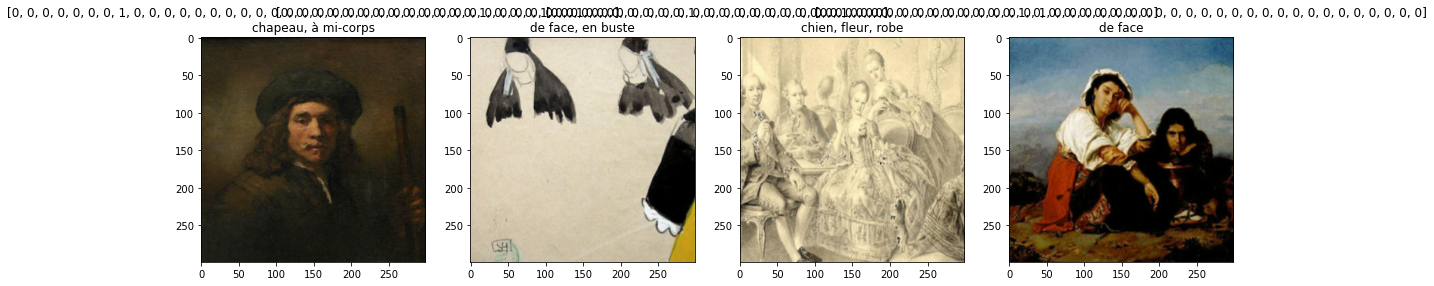

VAL SET
('C:\\Joconde\\joconde\\0506\\m504401_d-2986_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '50440001492')
('C:\\Joconde\\joconde\\0459\\m017202_0002995_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], '01720004041')
('C:\\Joconde\\joconde\\0022\\m065004_0100020x1_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], '06500100020')
('C:\\Joconde\\joconde\\0468\\m505886_gmtt-119-001-27801_p.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '50580000257')


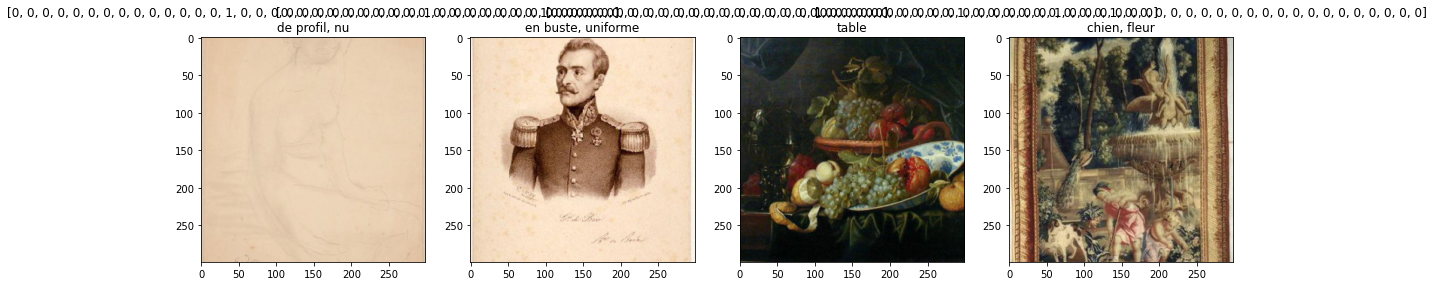

In [7]:
print('TRAIN SET')
show_random_images(train_loader.dataset, is_small=False, crop_idx=4)

print ('VAL SET')
show_random_images(val_loader.dataset,  is_small=False)

## Extract a Subset for binary classification

In [6]:
what = 'cheval'

train_subset = BinarySubset(train_set, what)
    
train_loader = torch.utils.data.DataLoader(
                     dataset=train_subset,
                     batch_size= batch_size,
                     shuffle=True,
                     drop_last = True,
                     num_workers= 2)

val_subset = BinarySubset(val_set, what)
    
val_loader = torch.utils.data.DataLoader(
                dataset=val_subset,
                batch_size=batch_size,
                shuffle=False,
                drop_last = True,
                num_workers=2)

test_subset = BinarySubset(test_set, what)
    
test_loader = torch.utils.data.DataLoader(
                dataset=test_subset,
                batch_size=batch_size,
                shuffle=False,
                drop_last = False,
                num_workers=2)


print('Training', train_subset)
print('    Labels:', train_subset.labels_count)
print()

print('Validation', val_subset)
print('    Labels:',val_subset.labels_count)
print()

print('Test', test_subset)
print('    Labels:', test_subset.labels_count)
print()

Training Dataset BinarySubset
    Number of datapoints: 11022
    Root location: C:/Joconde/joconde
    Number of classes: 2
    Number of positive labels: 5511
    Number of negative labels: 5511
    Labels: {'~cheval': 5511, 'cheval': 5511}

Validation Dataset BinarySubset
    Number of datapoints: 748
    Root location: C:/Joconde/joconde
    Number of classes: 2
    Number of positive labels: 374
    Number of negative labels: 374
    Labels: {'~cheval': 374, 'cheval': 374}

Test Dataset BinarySubset
    Number of datapoints: 748
    Root location: C:/Joconde/joconde
    Number of classes: 2
    Number of positive labels: 374
    Number of negative labels: 374
    Labels: {'~cheval': 374, 'cheval': 374}



### Load Model



In [7]:
torch.cuda.is_available()

True

In [8]:
model_finetuning = False
net = train.load_net(model_name = model_name, class_count=2, finetuning = model_finetuning)

#print(net)

### Training

In [9]:
learning_rate = 0.0001

epoch_count = 20

activation = train.set_activation(torch.sigmoid)

criterion = train.set_loss_criterion(nn.BCEWithLogitsLoss(), use_weights = False,  data_loader = train_loader) # nn.CrossEntropyLoss   BCEWithLogitsLoss

optimizer = train.set_optimizer(net, optim.Adam, learning_rate = learning_rate, print_parameters= False)
    
# decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)


decision = train.decision_by_threshold #decision_by_class_threshold
decision_param = 0.5

In [10]:
liveloss = PlotLosses()#(max_epoch=epoch_count , max_cols=2)
def plot_epoch (epoch_stats):
    liveloss.update(epoch_stats)
    liveloss.draw()

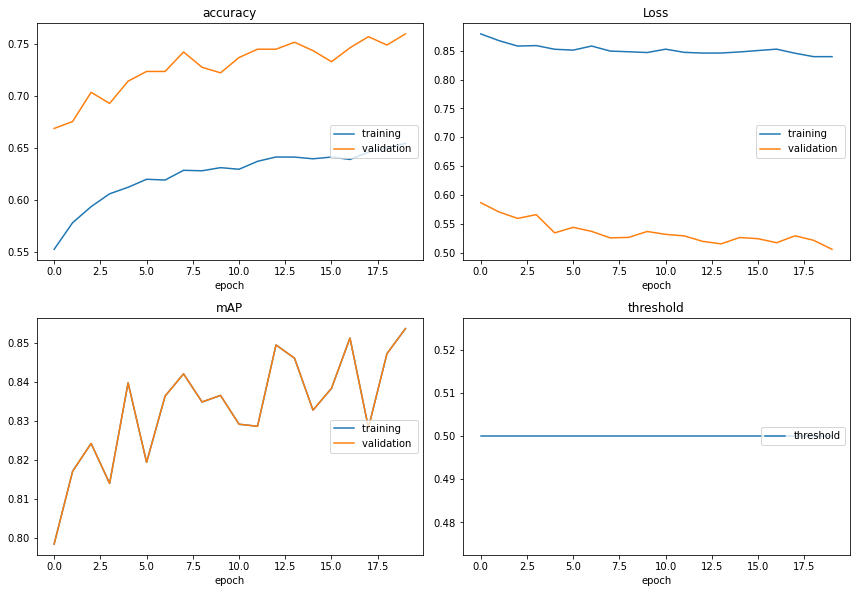

accuracy
	training         	 (min:    0.552, max:    0.654, cur:    0.654)
	validation       	 (min:    0.668, max:    0.759, cur:    0.759)
Loss
	training         	 (min:    0.840, max:    0.879, cur:    0.840)
	validation       	 (min:    0.506, max:    0.587, cur:    0.506)
mAP
	training         	 (min:    0.798, max:    0.854, cur:    0.854)
	validation       	 (min:    0.798, max:    0.854, cur:    0.854)
threshold
	threshold        	 (min:    0.500, max:    0.500, cur:    0.500)



In [12]:
net, _, elapsed_time = train.train(net, 
                                    criterion, optimizer, scheduler, 
                                    train_loader, val_loader,  
                                    activation, decision, decision_param,
                                    save_best_model=False, 
                                    epochs_num = epoch_count,  
                                    end_of_epoch_callback=plot_epoch,
                                    checkpoint_dir = '../../MonaLIA/output',
                                    checkpoint_prefix='inception_v3_Joconde_40_classes.cheval.test.1000.4.3')

In [36]:
best_acc_train = np.max([x.value for x in liveloss.logger.log_history['accuracy'] ])
best_acc_val = np.max([x.value for x in liveloss.logger.log_history['val_accuracy'] ])
best_epoch   = np.argmax([x.value for x in liveloss.logger.log_history['val_accuracy'] ]) + 1 

print('Best model training accuracy: %.4f' % best_acc_train)
print('Best model validation accuracy: %.4f' % best_acc_val)
print('Best model epoch: %d' % (best_epoch + 1) )
print('Training time: %s' % str(elapsed_time))

Best model training accuracy: 0.6447
Best model validation accuracy: 0.7232
Best model epoch: 8
Training time: 0:19:19.565156


In [13]:
checkpoint = torch.load('../../MonaLIA/output/inception_v3_Joconde_40_classes.cheval.test.1000.4.3.checkpoint.pth.tar')
print(checkpoint.keys())

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time', 'metrics_history'])


### Testing

In [14]:
activation = train.set_activation(torch.softmax)
decision = train.decision_by_threshold
decision_param = 0.5
scores = train.predict(net, test_loader, activation, decision, decision_param, print_frequency=100)


C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


images total: 100, correct: 85, acc: 85.0% , mAP: nan


C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


images total: 200, correct: 162, acc: 81.0% , mAP: nan


C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


images total: 300, correct: 244, acc: 81.3% , mAP: nan
images total: 400, correct: 322, acc: 80.5% , mAP: 0.665
images total: 500, correct: 392, acc: 78.4% , mAP: 0.803
images total: 600, correct: 472, acc: 78.7% , mAP: 0.850
images total: 700, correct: 545, acc: 77.9% , mAP: 0.858
images total: 748, correct: 577, acc: 77.1% , mAP: 0.858
Finished prediction


In [17]:
scores = scores.cpu() 
y_scores = scores.numpy()
y_true = np.array(test_loader.dataset.targets , dtype = np.dtype('B')) 
y_pred = decision(scores, decision_param).numpy().astype(np.dtype('B'))

In [18]:
prfs = metrics.precision_recall_fscore_support(y_true= y_true,
                                               y_pred= y_pred)

acc = metrics.accuracy_score(y_true= y_true,
                            y_pred= y_pred)



sim = metrics.jaccard_score(y_true= y_true,
                            y_pred= y_pred,
                            average='samples')

mAP =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average='macro')

In [19]:
report = metrics.classification_report(y_true= y_true,
                                 y_pred= y_pred, 
                                 target_names = test_loader.dataset.classes,
                                 output_dict = True)

ap =  metrics.average_precision_score(y_true= y_true,
                                       y_score=y_scores,
                                       average=None)

report_output = pd.concat((pd.Series([x for x in report] ),
                           pd.Series(list(train_loader.dataset.labels_count.values()) + 4 * [sum(train_loader.dataset.labels_count.values())]),
                           pd.Series(list(val_loader.dataset.labels_count.values()) + 4 * [sum(val_loader.dataset.labels_count.values())]),
                           pd.Series([x['support'] for x in report.values()]),
                           pd.Series([x['recall'] for x in report.values()]).round(3),
                           pd.Series([x['precision'] for x in report.values()]).round(3),
                           pd.Series([x['f1-score'] for x in report.values()]).round(3),
                           pd.Series(ap).round(3),
                           pd.Series(report['macro avg']['f1-score']).round(3),
                           pd.Series(acc).round(3),
                           pd.Series(mAP).round(3),
                           pd.Series(sim).round(3),
                           pd.Series(decision_param)
                           ), axis=1)
report_output.columns = ['class', 'train','val', 'support', 'recall', 'precision', 'f1-score', 'AP', 'f1 macroavg','acc', 'mAP', 'jaccard similarity score' , 'param']

report_output

,class,train,val,support,recall,precision,f1-score,AP,f1 macroavg,acc,mAP,jaccard similarity score,param
0,~cheval,5511,374,374,0.727,0.798,0.761,0.853,0.771,0.771,0.858,0.771,0.5
1,cheval,5511,374,374,0.816,0.749,0.781,0.863,NaN,NaN,NaN,NaN,NaN
2,micro avg,11022,748,748,0.771,0.771,0.771,NaN,NaN,NaN,NaN,NaN,NaN
3,macro avg,11022,748,748,0.771,0.774,0.771,NaN,NaN,NaN,NaN,NaN,NaN
4,weighted avg,11022,748,748,0.771,0.774,0.771,NaN,NaN,NaN,NaN,NaN,NaN
5,samples avg,11022,748,748,0.771,0.771,0.771,NaN,NaN,NaN,NaN,NaN,NaN


### Save Network parameters (if needed)

In [ ]:
torch.save(net.state_dict(), '../../MonaLIA/Model Parameters/inception_v3_Joconde_40_classes.cheval.test.1000.4.3.pth')

#### Reload Network parameters (if needed)

In [7]:
net.load_state_dict(torch.load('../../MonaLIA/Model Parameters/inception_v3_Joconde_40_classes.cheval.test.1000.4.3.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Find an optimal threshold 

In [36]:
train.th_internal_validation(val_set, scores)

0.7500000000000002

### Visualize random test predictions

image,crop,labels,prediction
,,[1 0]~chevalreprésentation animalière (chien)M0810004948C:\Joconde\joconde\0466\m081003_032211_p.jpg,[0 1]cheval : 0.693~cheval : 0.307
,,"[0 1]chevalscène (cavalier, pipe, campement, tente,drapeau) ; fond de paysage (champ)M0332001803C:\Joconde\joconde\0700\m033204_002084_p.jpg",[0 1]cheval : 0.935~cheval : 0.065
,,"[0 1]chevalscène (Guerre de 1870, Mouzon, combat,chemin, groupe de figures (soldat),cheval, charrette, mort)M0144004374C:\Joconde\joconde\0538\m014402_001069_p.jpg",[0 1]cheval : 0.687~cheval : 0.313
,,"[0 1]chevalavers : figure mythologique (Aréthuse,tête, dauphin, perle, diadème) ;#revers: figure (cavalier, cheval)08150001396C:\Joconde\joconde\0514\m081583_0001394_p.jpg",[0 1]cheval : 0.776~cheval : 0.224
,,"[0 1]chevalscène (soldat, cavalier, général, homme,pauvre, bateau à rames)02110008531C:\Joconde\joconde\0686\m021102_0002410_p.jpg",[0 1]cheval : 0.965~cheval : 0.035

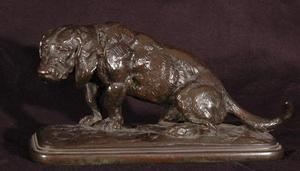
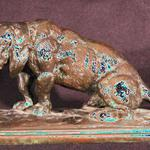
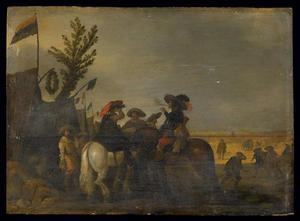
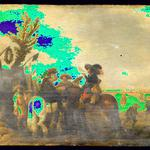
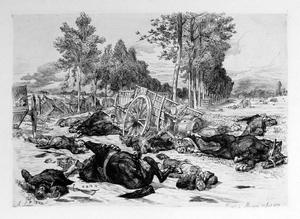
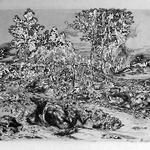
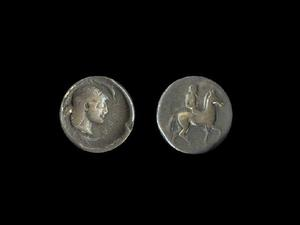
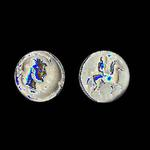
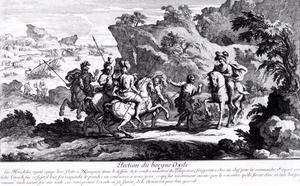
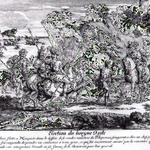

In [26]:
rows = 5
#y_pred_v =decision(scores, decision_param).numpy()
   
#testset_idx_pick = np.arange(rows)    
testset_idx_pick = np.random.randint(0, len(test_loader.dataset.samples), size=rows)

HTML(visualizer.visualize_classification_HTML(test_loader.dataset, y_pred, y_scores, testset_idx_pick))

<Figure size 432x288 with 0 Axes>

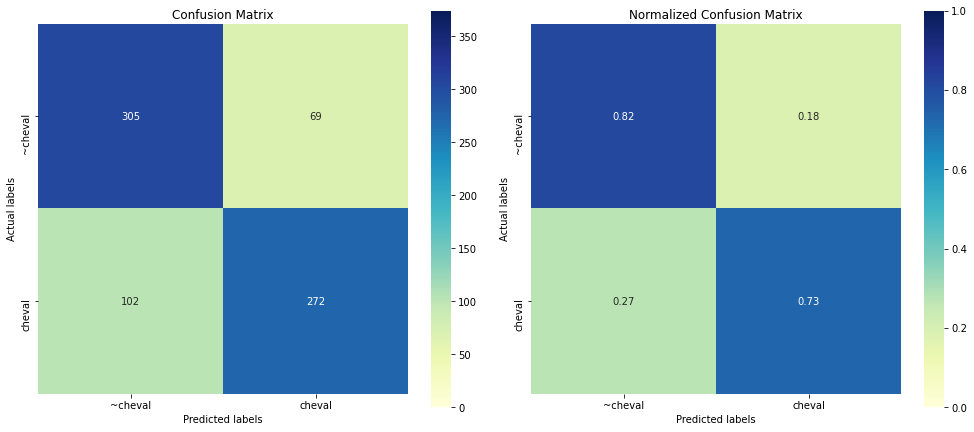

In [27]:
from MonaLIA.util.visualization_helpers import show_confusion_matrix
from MonaLIA.util.visualization_helpers import target_to_text, prediction_to_text

#y_true = np.array(test_set.targets)
#y_pred = decision(scores[:,1:], decision_param).numpy()

tick_labels= test_loader.dataset.classes

if(multi_label):
    y_true_text = [target_to_text(test_loader.dataset.classes, list(x), separator='+') for x in y_true]
    y_pred_text = [target_to_text(test_loader.dataset.classes, list(x), separator='+') for x in y_pred]
    tick_labels = sorted(set(y_true_text).union(y_pred_text))
    
show_confusion_matrix(y_true_text, y_pred_text, test_loader.dataset.classes)

## Image size statistics

In [28]:
width = np.array([])
height=  np.array([])
ar = np.array([])
data_sets = [train_set, val_set, test_set]

for a_set in data_sets:
    for _, (img, _) in enumerate(a_set): 
        width = np.append(width, img.shape[1])
        height = np.append(height, img.shape[2])
        #ar = np.append(ar, ((img.shape[1] / img.shape[2]) if img.shape[1] > img.shape[2] else (img.shape[2] / img.shape[1])))
        ar = np.append(ar, (img.shape[1] / img.shape[2]))
        
print( ar.max(), ar.min() , ar.mean())

1.0 1.0 1.0


<Figure size 432x288 with 0 Axes>

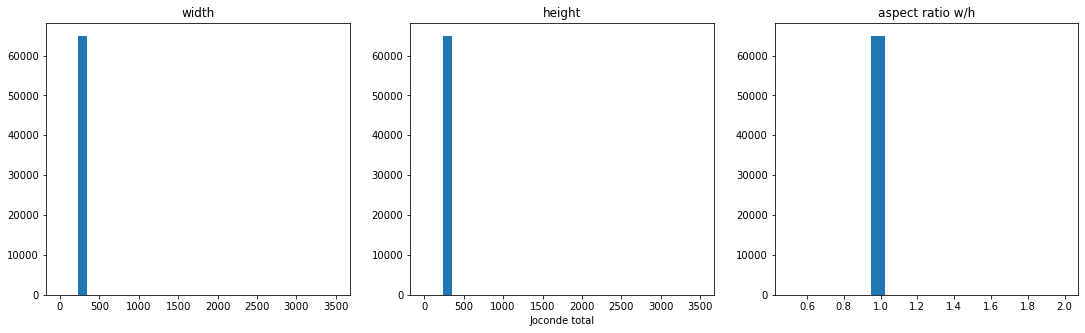

In [30]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=3,  gridspec_kw = {'width_ratios':[1, 1, 1]})
fig.set_size_inches(18.5, 5)

axes[0].set_title('width')
axes[0].hist(width, bins=30, range=(0,3500))
axes[1].set_title('height')
axes[1].set_xlabel('Joconde total')
axes[1].hist(height, bins=30, range=(0,3500))
axes[2].set_title('aspect ratio w/h')
axes[2].hist(ar, bins=20 , range=(0.5 , 2))
plt.show()

## Scrapbook